<a href="https://colab.research.google.com/github/imthelizardking/cmp719-project/blob/main/cmp719_project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Main text

Mount gdrive for saving weights etc.

In [14]:
from google.colab import drive
drive.mount('/content/drive/')
!cd '/content/drive/MyDrive'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Import required packages

In [15]:
!pip install torch torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
#import torch.nn.functional as F

ResNet-56 Model:

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)  # Skip connection
        out = self.relu(out)
        return out

class ResNet56(nn.Module):
    def __init__(self, num_classes):
        super(ResNet56, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 9, stride=1)
        self.layer2 = self._make_layer(32, 9, stride=2)
        self.layer3 = self._make_layer(64, 9, stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.ReLU()(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = nn.AdaptiveAvgPool2d(1)(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

Set configuration for training ResNet-56 w/ cifar-100:

In [16]:
# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda")

custom_transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

custom_transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load CIFAR-100 dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=custom_transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=custom_transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Create ResNet-56 model instance
model_resnet56 = ResNet56(num_classes=100).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
EPOCHS_RESNET56 = 100
LEARNING_RATE_RESNET56 = 0.001
optimizer = optim.AdamW(model_resnet56.parameters(), lr=LEARNING_RATE_RESNET56)

Train ResNet-56 w/ cifar-100

In [ ]:
# Training loop
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for epoch in range(EPOCHS_RESNET56):  # Number of epochs
    model_resnet56.train()
    train_loss = 0
    train_accuracy = 0
    test_loss = 0
    test_accuracy = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model_resnet56(inputs)
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print('#', epoch+1, ' epoch train loss: ', train_loss / len(trainloader))
    train_losses.append(train_loss / len(trainloader))
    # Validation
    model_resnet56.eval()
    correct = 0
    total = 0
    torch._to_functional_tensor = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model_resnet56(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    print('Accuracy on training set after epoch %d: %.2f %%' % (epoch + 1, train_accuracy))
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model_resnet56(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = test_loss / len(testloader)
    test_losses.append(test_loss / len(testloader))
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    print('Accuracy on test set after epoch %d: %.2f %%' % (epoch + 1, test_accuracy))
print('Training finished.')

# 1  epoch train loss:  4.0852354011877114
Accuracy on training set after epoch 1: 10.36 %
Accuracy on test set after epoch 1: 10.53 %
# 2  epoch train loss:  3.530381202697754
Accuracy on training set after epoch 2: 16.37 %
Accuracy on test set after epoch 2: 17.01 %
# 3  epoch train loss:  3.0837778356069188
Accuracy on training set after epoch 3: 22.16 %
Accuracy on test set after epoch 3: 22.76 %
# 4  epoch train loss:  2.7740204767193024
Accuracy on training set after epoch 4: 27.05 %
Accuracy on test set after epoch 4: 26.20 %
# 5  epoch train loss:  2.519889972398958
Accuracy on training set after epoch 5: 34.25 %
Accuracy on test set after epoch 5: 33.95 %
# 6  epoch train loss:  2.3221513328649808
Accuracy on training set after epoch 6: 38.46 %
Accuracy on test set after epoch 6: 38.44 %
# 7  epoch train loss:  2.1522134591246505
Accuracy on training set after epoch 7: 41.64 %
Accuracy on test set after epoch 7: 40.53 %
# 8  epoch train loss:  2.0246778647308155
Accuracy on tr

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy on training set after epoch 12: 52.32 %
Accuracy on test set after epoch 12: 49.02 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'    
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

# 13  epoch train loss:  1.5782704078937735


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy on training set after epoch 13: 57.52 %
Accuracy on test set after epoch 13: 52.68 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

# 14  epoch train loss:  1.5138856230489433


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy on training set after epoch 14: 57.77 %
Accuracy on test set after epoch 14: 53.21 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

# 15  epoch train loss:  1.459781635142958


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy on training set after epoch 15: 57.22 %
Accuracy on test set after epoch 15: 52.71 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

# 16  epoch train loss:  1.4081135314443838


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    AssertionError: self._shutdown_workers()
can only test a child process  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():
  File "/usr/lib/

Accuracy on training set after epoch 16: 57.71 %
Accuracy on test set after epoch 16: 51.63 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

# 17  epoch train loss:  1.36586770407684


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>if w.is_alive():
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

Accuracy on training set after epoch 17: 60.77 %
Accuracy on test set after epoch 17: 55.49 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

# 18  epoch train loss:  1.3172995553297155


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy on training set after epoch 18: 61.31 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

AssertionError:     can only test a child processif w.is_alive():

  File "/usr/lib/

Accuracy on test set after epoch 18: 54.96 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
if w.is_alive():
  File "/usr/lib

# 19  epoch train loss:  1.2741037242857696


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy on training set after epoch 19: 59.41 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a

Accuracy on test set after epoch 19: 52.63 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

# 20  epoch train loss:  1.242159666917513
Accuracy on training set after epoch 20: 63.54 %
Accuracy on test set after epoch 20: 56.48 %
# 21  epoch train loss:  1.1997913570355272
Accuracy on training set after epoch 21: 62.26 %
Accuracy on test set after epoch 21: 54.51 %
# 22  epoch train loss:  1.1693617369207885
Accuracy on training set after epoch 22: 64.69 %
Accuracy on test set after epoch 22: 56.53 %
# 23  epoch train loss:  1.1384695654025163
Accuracy on training set after epoch 23: 66.13 %
Accuracy on test set after epoch 23: 57.10 %
# 24  epoch train loss:  1.1020908700230787
Accuracy on training set after epoch 24: 67.93 %
Accuracy on test set after epoch 24: 58.84 %
# 25  epoch train loss:  1.0755139691445528
Accuracy on training set after epoch 25: 67.90 %
Accuracy on test set after epoch 25: 58.16 %
# 26  epoch train loss:  1.0470760571377358
Accuracy on training set after epoch 26: 66.74 %
Accuracy on test set after epoch 26: 57.45 %
# 27  epoch train loss:  1.01467508

Plot Results:

Training and Test Losses:

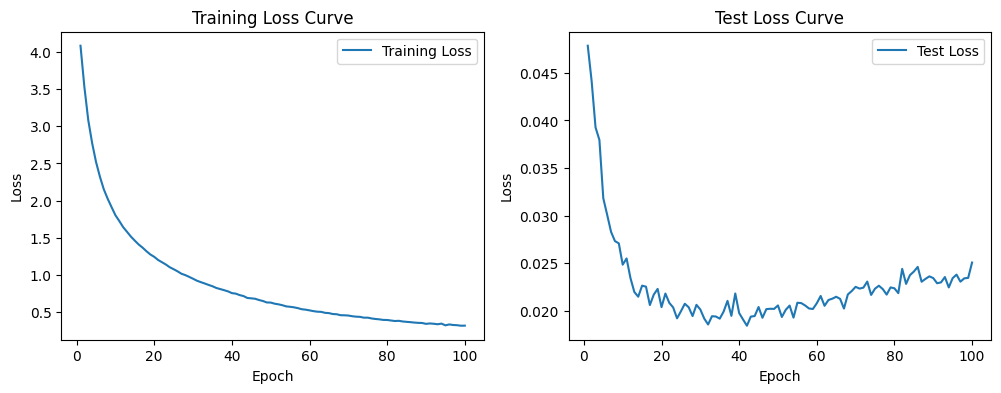

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS_RESNET56+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS_RESNET56+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss Curve')
plt.legend()
plt.savefig('/content/drive/MyDrive/719_project/results/resnet56_losses.png')

Training and Test Accuracies:

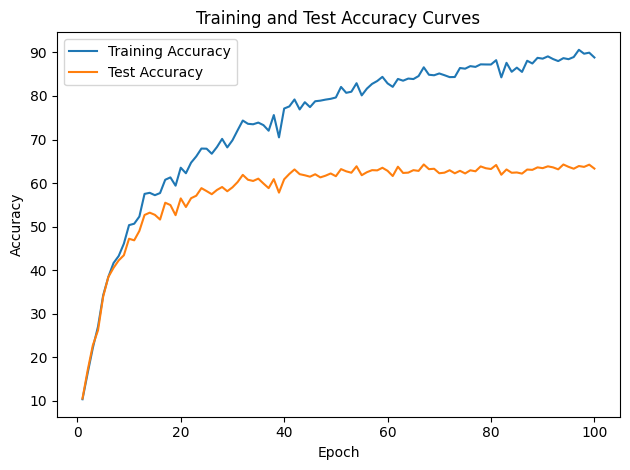

In [ ]:
# Plotting the training accuracy curve
plt.plot(range(1, EPOCHS_RESNET56+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, EPOCHS_RESNET56+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/719_project/results/resnet56_accuracies.png')
plt.show()

Save trained ResNet-56 weights:

In [ ]:
torch.save(model_resnet56.state_dict(), '/content/drive/MyDrive/719_project/trained_weights/resnet_model_weights.pth')

Calculate Top-1 accuracy for trained ResNet-56 model and cifar-100 dataset (in paper, 70.43%):

In [ ]:
with torch.no_grad(): # for making sure there is no training, just inference
    model_resnet56.eval()  # model to eval. mode
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_resnet56(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

top1_accuracy = 100 * correct / total
print('Top-1 Accuracy: {:.2f}%'.format(top1_accuracy))

Top-1 Accuracy: 41.61%


# **Vision Transformer w/ Feature Guidance:**

Imports:

In [30]:
!pip install timm
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from timm import create_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.6 MB/s eta 0:00:00


In [31]:
model_name = "vit_base_patch16_224"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
# create a ViT model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
model = create_model(model_name, pretrained=True).to(device)

device =  cuda


In [32]:
# Define transforms for test
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

In [33]:
%%capture
# ImageNet Labels
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

# Demo Image
!wget https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true -O santorini.png
img = PIL.Image.open('santorini.png')
img_tensor = transforms(img).unsqueeze(0).to(device)

In [ ]:
# end-to-end inference
output = model(img_tensor)

Inference Result:
church, church_building



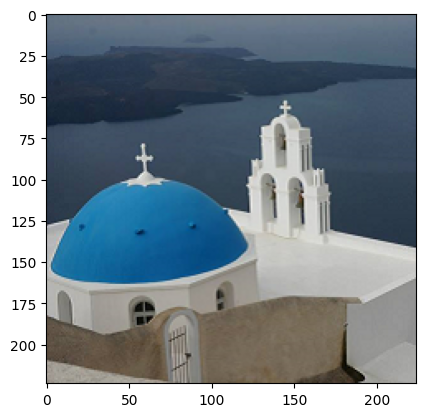

In [36]:
print("Inference Result:")
print(imagenet_labels[int(torch.argmax(output))])
plt.imshow(img)

Set training configuration for Vision Transformer w/ feature guidance

In [28]:
# Set up hyperparameters and data loaders
torch.cuda.empty_cache()
image_size = 32
patch_size = 16
num_classes = 100
dim = 128 #64
depth = 7 #10
heads = 4
token_dim = 128
mlp_dim = 256 #512
batch_size = 128
learning_rate = 1e-3
epochs = 50
BETA = 2.5 # scaler for feature guidance loss
device = torch.device("cuda")


# Create an instance of the model


model_ViT = T2TViT(
    dim=128,
    image_size=224,
    num_classes=100,
    channels=3,
    depth = 7,
    heads = 4,
    mlp_dim = 512
).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ViT.parameters(), lr=learning_rate, weight_decay=0.01)
model_ViT.to(device)

# Create data loaders (replace with your own datasets)
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=custom_transform_train)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified


If pre-trained weights will be used, run following code snippet:

In [ ]:
model_ViT.load_state_dict(torch.load('/content/drive/MyDrive/719_project/trained_weights/ViT_model_weights.pth'))

Vision Transformer Trainer:

In [29]:
# Training loop
#model_resnet56.eval() # no training for cnn, just eval.
model_ViT.train()
for epoch in range(epochs):
    train_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        # zero grads
        optimizer.zero_grad()
        # Forward pass
        outputs = model_ViT(images)
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_train_loss:.4f}")

Epoch 1/50 - Loss: 4.2375
Epoch 2/50 - Loss: 4.1137
Epoch 3/50 - Loss: 4.1062
Epoch 4/50 - Loss: 4.0838
Epoch 5/50 - Loss: 4.0600
Epoch 6/50 - Loss: 4.0442
Epoch 7/50 - Loss: 4.0386
Epoch 8/50 - Loss: 4.0257
Epoch 9/50 - Loss: 4.0137
Epoch 10/50 - Loss: 3.9917
Epoch 11/50 - Loss: 3.9817
Epoch 12/50 - Loss: 3.9793
Epoch 13/50 - Loss: 3.9743
Epoch 14/50 - Loss: 3.9767
Epoch 15/50 - Loss: 3.9728
Epoch 16/50 - Loss: 3.9724
Epoch 17/50 - Loss: 3.9670
Epoch 18/50 - Loss: 3.9687
Epoch 19/50 - Loss: 3.9659
Epoch 20/50 - Loss: 3.9640
Epoch 21/50 - Loss: 3.9654
Epoch 22/50 - Loss: 3.9623
Epoch 23/50 - Loss: 3.9630
Epoch 24/50 - Loss: 3.9607
Epoch 25/50 - Loss: 3.9561
Epoch 26/50 - Loss: 3.9570
Epoch 27/50 - Loss: 3.9552
Epoch 28/50 - Loss: 3.9533
Epoch 29/50 - Loss: 3.9517
Epoch 30/50 - Loss: 3.9508
Epoch 31/50 - Loss: 3.9458


KeyboardInterrupt: ignored

Calculate Top-1 Accuracy for Vision Transformer w/ feature guidance:

In [ ]:
torch.save(model_ViT.state_dict(), '/content/drive/MyDrive/719_project/trained_weights/ViT_model_weights.pth')

In [ ]:
with torch.no_grad(): # for making sure there is no training, just inference
    model_ViT.eval()  # model to eval. mode
    total, correct = 0, 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_ViT(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
top1_accuracy = 100 * correct / total
print('Top-1 Accuracy: {:.2f}%'.format(top1_accuracy))

Top-1 Accuracy: 7.43%


# TEMP:

In [ ]:
# Define the training loop
def train_ViT_with_fg(model_ViT, model_cnn, dataloader, criterion, optimizer, device, BETA):

    ###def get_features_hook(module, input, output):
      #### Store the intermediate features in a global variable
      ###global student_features
      ###student_features = output
    ###def get_teacher_features_hook(module, input, output):
        #### Store the intermediate features in a global variable
        ###global teacher_features
        ###teacher_features = output

    model_cnn.eval() # no training for cnn, just eval.
    model_ViT.train()
    total_loss = 0.0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        #images, labels = images.cuda(), labels.cuda() # add this line

        optimizer.zero_grad()
        outputs = model_ViT(images)

        #### hook cnn and ViT for intermediate feature extraction #
        ###criterion_fg = nn.MSELoss()
        ###model_ViT.register_forward_hook(get_features_hook)
        #### Register a forward hook to extract features from the teacher model
        ###model_cnn.register_forward_hook(get_teacher_features_hook)
        ####loss_fg = criterion_fg(student_features, teacher_features.detach())  # detach the teacher features to prevent backpropagation through the teacher
        ###loss_fg = 0
        # hook cnn and ViT for intermediate feature extraction #
        loss_cls = criterion(outputs, labels) # cross-entropy loss
        loss = loss_cls + BETA * 0 # loss_fg
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
    return total_loss / len(dataloader.dataset)